# Systolic Array Design

In [261]:
import pyrtl
from hardware_accelerators import *

from IPython.display import *
import numpy as np

## OpenTPU Code

`matrix.py`

In [311]:
from functools import reduce
from pyrtl import *
from pyrtl import rtllib
from pyrtl.rtllib import multipliers

### Multiply and Accumulate Unit (MAC)

In [23]:
# set_debug_mode()
globali = 0  # To give unique numbers to each MAC


def MAC(
    data_width, matrix_size, data_in, acc_in, switchw, weight_in, weight_we, weight_tag
):
    """Multiply-Accumulate unit with programmable weight.
    Inputs
    data_in: The 8-bit activation value to multiply by weight.
    acc_in: 32-bit value to accumulate with product.
    switchw: Control signal; when 1, switch to using the other weight buffer.
    weight_in: 8-bit value to write to the secondary weight buffer.
    weight_we: When high, weights are being written; if tag matches, store weights.
               Otherwise, pass them through with incremented tag.
    weight_tag: If equal to 255, weight is for this row; store it.

    Outputs
    out: Result of the multiply accumulate; moves one cell down to become acc_in.
    data_reg: data_in, stored in a pipeline register for cell to the right.
    switch_reg: switchw, stored in a pipeline register for cell to the right.
    weight_reg: weight_in, stored in a pipeline register for cell below.
    weight_we_reg: weight_we, stored in a pipeline register for cell below.
    weight_tag_reg: weight_tag, incremented and stored in a pipeline register for cell below
    """
    global globali
    # Check lengths of inupts
    if len(weight_in) != len(data_in) != data_width:
        raise Exception("Expected 8-bit value in MAC.")
    if len(switchw) != len(weight_we) != 1:
        raise Exception("Expected 1-bit control signal in MAC.")

    # Should never switch weight buffers while they're changing
    # rtl_assert(~(weight_we & switchw), Exception("Cannot switch weight values when they're being loaded!"))

    # Use two buffers to store weight and next weight to use.
    wbuf1, wbuf2 = Register(len(weight_in), f"MAC{globali}_wbuf1"), Register(
        len(weight_in), f"MAC{globali}_wbuf2"
    )

    # Track which buffer is current and which is secondary.
    current_buffer_reg = Register(1, f"MAC{globali}_cur_buf")
    with conditional_assignment:
        with switchw:
            current_buffer_reg.next |= ~current_buffer_reg
    current_buffer = (
        current_buffer_reg ^ switchw
    )  # reflects change in same cycle switchw goes high

    # When told, store a new weight value in the secondary buffer
    with conditional_assignment:
        with weight_we & (weight_tag == Const(matrix_size - 1)):
            with current_buffer == 0:  # If 0, wbuf1 is current; if 1, wbuf2 is current
                wbuf2.next |= weight_in
            with otherwise:
                wbuf1.next |= weight_in

    # Do the actual MAC operation
    weight = select(current_buffer, wbuf2, wbuf1)
    # probe(weight, "weight" + str(globali))
    globali += 1
    # inlen = max(len(weight), len(data_in))
    # product = weight.sign_extended(inlen*2) * data_in.sign_extended(inlen*2)
    # product = product[:inlen*2]
    product = (weight * data_in)[:32]
    # plen = len(weight) + len(data_in)
    # product = weight.sign_extended(plen) * data_in.sign_extended(plen)
    # product = product[:plen]
    l = max(len(product), len(acc_in)) + 1
    out = (product.sign_extended(l) + acc_in.sign_extended(l))[:-1]

    # product = rtllib.multipliers.signed_tree_multiplier(weight, data_in)
    # l = max(len(product), len(acc_in))
    # out = product.sign_extended(l) + acc_in.sign_extended(l)

    if len(out) > 32:
        out = out[:32]

    # For values that need to be forward to the right/bottom, store in pipeline registers
    data_reg = Register(
        len(data_in), f"MAC{globali}_data_reg"
    )  # pipeline register, holds data value for cell to the right
    data_reg.next <<= data_in
    switch_reg = Register(
        1, f"MAC{globali}_switch_reg"
    )  # pipeline register, holds switch control signal for cell to the right
    switch_reg.next <<= switchw
    acc_reg = Register(
        len(out), f"MAC{globali}_accumulator_reg"
    )  # output value for MAC below
    acc_reg.next <<= out
    weight_reg = Register(
        len(weight_in), f"MAC{globali}_weight_reg"
    )  # pipeline register, holds weight input for cell below
    weight_reg.next <<= weight_in
    weight_we_reg = Register(
        1, f"MAC{globali}_weight_we"
    )  # pipeline register, holds weight write enable signal for cell below
    weight_we_reg.next <<= weight_we
    weight_tag_reg = Register(
        len(weight_tag), f"MAC{globali}_weight_tag"
    )  # pipeline register, holds weight tag for cell below
    weight_tag_reg.next <<= (weight_tag + 1)[
        : len(weight_tag)
    ]  # increment tag as it passes down rows

    return acc_reg, data_reg, switch_reg, weight_reg, weight_we_reg, weight_tag_reg

### Matrix Multiply Array (systolic)

In [24]:
def MMArray(data_width, matrix_size, data_in, new_weights, weights_in, weights_we):
    """
    data_in: 256-array of 8-bit activation values from systolic_setup buffer
    new_weights: 256-array of 1-bit control values indicating that new weight should be used
    weights_in: output of weight FIFO (8 x matsize x matsize bit wire)
    weights_we: 1-bit signal to begin writing new weights into the matrix
    """

    # For signals going to the right, store in a var; for signals going down, keep a list
    # For signals going down, keep a copy of inputs to top row to connect to later
    weights_in_top = [
        WireVector(data_width, f"weight_in_{i}") for i in range(matrix_size)
    ]  # input weights to top row
    weights_in_last = [x for x in weights_in_top]
    weights_enable_top = [
        WireVector(1, f"weight_enable_{i}") for i in range(matrix_size)
    ]  # weight we to top row
    weights_enable = [x for x in weights_enable_top]
    weights_tag_top = [
        WireVector(data_width, f"weight_tag_{i}") for i in range(matrix_size)
    ]  # weight row tag to top row
    weights_tag = [x for x in weights_tag_top]
    data_out = [Const(0) for i in range(matrix_size)]  # will hold output from final row
    # Build array of MACs
    for i in range(matrix_size):  # for each row
        din = data_in[i]
        switchin = new_weights[i]
        # probe(switchin, "switch" + str(i))
        for j in range(matrix_size):  # for each column
            acc_out, din, switchin, newweight, newwe, newtag = MAC(
                data_width,
                matrix_size,
                din,
                data_out[j],
                switchin,
                weights_in_last[j],
                weights_enable[j],
                weights_tag[j],
            )
            # probe(data_out[j], "MACacc{}_{}".format(i, j))
            # probe(acc_out, "MACout{}_{}".format(i, j))
            # probe(din, "MACdata{}_{}".format(i, j))
            weights_in_last[j] = newweight
            weights_enable[j] = newwe
            weights_tag[j] = newtag
            data_out[j] = acc_out

    # Handle weight reprogramming
    programming = Register(
        1, "weight_programming_reg"
    )  # when 1, we're in the process of loading new weights
    size = 1
    while pow(2, size) < matrix_size:
        size = size + 1
    progstep = Register(
        size, "progstep_reg"
    )  # 256 steps to program new weights (also serves as tag input)
    with conditional_assignment:
        with weights_we & (~programming):
            programming.next |= 1
        with programming & (progstep == matrix_size - 1):
            programming.next |= 0
        with otherwise:
            pass
        with programming:  # while programming, increment state each cycle
            progstep.next |= progstep + 1
        with otherwise:
            progstep.next |= Const(0)

    # Divide FIFO output into rows (each row datawidth x matrixsize bits)
    rowsize = data_width * matrix_size
    weight_arr = [
        weights_in[i * rowsize : i * rowsize + rowsize] for i in range(matrix_size)
    ]
    # Mux the wire for this row
    current_weights_wire = mux(progstep, *weight_arr)
    # Split the wire into an array of 8-bit values
    current_weights = [
        current_weights_wire[i * data_width : i * data_width + data_width]
        for i in reversed(range(matrix_size))
    ]

    # Connect top row to input and control signals
    for i, win in enumerate(weights_in_top):
        # From the current 256-array, select the byte for this column
        win <<= current_weights[i]
    for we in weights_enable_top:
        # Whole row gets same signal: high when programming new weights
        we <<= programming
    for wt in weights_tag_top:
        # Tag is same for whole row; use state index (runs from 0 to 255)
        wt <<= progstep

    return [x.sign_extended(32) for x in data_out]

### Accumulators

In [25]:
def accum(size, data_in, waddr, wen, wclear, raddr, lastvec, id):
    """A single 32-bit accumulator with 2^size 32-bit buffers.
    On wen, writes data_in to the specified address (waddr) if wclear is high;
    otherwise, it performs an accumulate at the specified address (buffer[waddr] += data_in).
    lastvec is a control signal indicating that the operation being stored now is the
    last vector of a matrix multiply instruction (at the final accumulator, this becomes
    a "done" signal).
    """

    mem = MemBlock(bitwidth=32, addrwidth=size, name=f"accumulator_memory_{id}")

    # Writes
    with conditional_assignment:
        with wen:
            with wclear:
                mem[waddr] |= data_in
            with otherwise:
                mem[waddr] |= (data_in + mem[waddr])[: mem.bitwidth]

    # Read
    data_out = mem[raddr]

    # Pipeline registers
    waddrsave = Register(len(waddr), f"acc_waddrsave_{id}")
    waddrsave.next <<= waddr
    wensave = Register(1, f"acc_wensave_{id}")
    wensave.next <<= wen
    wclearsave = Register(1, f"acc_wclearsave_{id}")
    wclearsave.next <<= wclear
    lastsave = Register(1, f"acc_lastsave_{id}")
    lastsave.next <<= lastvec

    return data_out, waddrsave, wensave, wclearsave, lastsave


def accumulators(accsize, datas_in, waddr, we, wclear, raddr, lastvec):
    """
    Produces array of accumulators of same dimension as datas_in.
    """

    # probe(we, "accum_wen")
    # probe(wclear, "accum_wclear")
    # probe(waddr, "accum_waddr")

    accout = [None for i in range(len(datas_in))]
    waddrin = waddr
    wein = we
    wclearin = wclear
    lastvecin = lastvec
    for i, x in enumerate(datas_in):
        # probe(x, "acc_{}_in".format(i))
        # probe(wein, "acc_{}_we".format(i))
        # probe(waddrin, "acc_{}_waddr".format(i))
        dout, waddrin, wein, wclearin, lastvecin = accum(
            accsize, x, waddrin, wein, wclearin, raddr, lastvecin, i
        )
        accout[i] = dout
        done = lastvecin

    return accout, done

### Weight FIFO

In [37]:
def FIFO(matsize, mem_data, mem_valid, advance_fifo):
    """
    matsize is the length of one row of the Matrix.
    mem_data is the connection from the DRAM controller, which is assumed to be 64 bytes wide.
    mem_valid is a one bit control signal from the controller indicating that the read completed and the current value is valid.
    advance_fifo signals to drop the tile at the end of the FIFO and advance everything forward.

    Output
    tile, ready, full
    tile: entire tile at the front of the queue (8 x matsize x matsize bits)
    ready: the tile output is valid
    full: there is no room in the FIFO
    """

    # probe(mem_data, "fifo_dram_in")
    # probe(mem_valid, "fifo_dram_valid")
    # probe(advance_fifo, "weights_advance_fifo")

    # Make some size parameters, declare state register
    totalsize = matsize * matsize  # total size of a tile in bytes
    tilesize = totalsize * 8  # total size of a tile in bits
    ddrwidth = int(len(mem_data) / 8)  # width from DDR in bytes (typically 64)
    size = 1
    while pow(2, size) < (
        totalsize / ddrwidth
    ):  # compute log of number of transfers required
        size = size + 1
    state = Register(
        size, "fifo_state"
    )  # Number of reads to receive (each read is ddrwidth bytes)
    startup = Register(1, "fifo_startup")
    startup.next <<= 1

    # probe(state, "fifo_state")

    # Declare top row of buffer: need to write to it in ddrwidth-byte chunks
    topbuf = [
        Register(ddrwidth * 8, f"fifo_topbuf_{i}")
        for i in range(max(1, int(totalsize / ddrwidth)))
    ]

    # Latch command to advance FIFO, since it may not complete immediately
    droptile = Register(1, "fifo_droptile")
    clear_droptile = WireVector(1)
    with conditional_assignment:
        with advance_fifo:
            droptile.next |= 1
        with clear_droptile:
            droptile.next |= 0

    # probe(droptile, "fifo_droptile")
    # probe(clear_droptile, "fifo_clear_droptile")

    # When we get data from DRAM controller, write to next buffer space
    with conditional_assignment:
        with mem_valid:
            state.next |= (
                state + 1
            )  # state tracks which ddrwidth-byte chunk we're writing to
            for i, reg in enumerate(
                reversed(topbuf)
            ):  # enumerate a decoder for write-enable signals
                # probe(reg, "fifo_reg{}".format(i))
                with state == Const(i, bitwidth=size):
                    reg.next |= mem_data

    # Track when first buffer is filled and when data moves out of it
    full = Register(1, "fifo_full")  # goes high when last chunk of top buffer is filled
    cleartop = WireVector(1, "fifo_cleartop")
    with conditional_assignment:
        with mem_valid & (
            state == Const(len(topbuf) - 1)
        ):  # writing the last buffer spot now
            full.next |= 1
        with cleartop:  # advancing FIFO, so buffer becomes empty
            full.next |= 0

    # Build buffers for remainder of FIFO
    buf2, buf3, buf4 = (
        Register(tilesize, "fifo_buf2"),
        Register(tilesize, "fifo_buf3"),
        Register(tilesize, "fifo_buf4"),
    )
    # probe(concat_list(topbuf), "buf1")
    # probe(buf2, "buf2")
    # probe(buf3, "buf3")
    # probe(buf4, "buf4")
    # probe(full, "buf1_full")
    # If a given row is empty, track that so we can fill immediately
    empty2, empty3, empty4 = (
        Register(1, "fifo_empty2"),
        Register(1, "fifo_empty3"),
        Register(1, "fifo_empty4"),
    )
    # probe(empty2, "buf2_empty")
    # probe(empty3, "buf3_empty")
    # probe(empty4, "buf4_empty")

    # Handle moving data between the buffers
    with conditional_assignment:
        with ~startup:
            empty2.next |= 1
            empty3.next |= 1
            empty4.next |= 1
        with full & empty2:  # First buffer is full, second is empty
            buf2.next |= concat_list(topbuf)  # move data to second buffer
            cleartop |= 1  # empty the first buffer
            empty2.next |= 0  # mark the second buffer as non-empty
        with empty3 & ~empty2:  # Third buffer is empty and second is full
            buf3.next |= buf2
            empty3.next |= 0
            empty2.next |= 1
        with empty4 & ~empty3:  # Fourth buffer is empty and third is full
            buf4.next |= buf3
            empty4.next |= 0
            empty3.next |= 1
        with droptile:
            empty4.next |= (
                1  # mark fourth buffer as free; tiles will advance automatically
            )
            clear_droptile |= 1

    ready = (
        startup & (~empty4) & (~droptile)
    )  # there is data in final buffer and we're not about to change it

    return buf4, ready, full

### Systolic Setup (activation inputs)

In [27]:
def systolic_setup(
    data_width, matsize, vec_in, waddr, valid, clearbit, lastvec, switch
):
    """Buffers vectors from the unified SRAM buffer so that they can be fed along diagonals to the
    Matrix Multiply array.

    matsize: row size of Matrix
    vec_in: row read from unified buffer
    waddr: the accumulator address this vector is bound for
    valid: this is a valid vector; write it when done
    clearbit: if 1, store result (default accumulate)
    lastvec: this is the last vector of a matrix
    switch: use the next weights tile beginning with this vector

    Output
    next_row: diagonal cross-cut of vectors to feed to MM array
    switchout: switch signals for MM array
    addrout: write address for first accumulator
    weout: write enable for first accumulator
    clearout: clear signal for first accumulator
    doneout: done signal for first accumulator
    """

    # Use a diagonal set of buffer so that when a vector is read from SRAM, it "falls" into
    # the correct diagonal pattern.
    # The last column of buffers need extra bits for control signals, which propagate down
    # and into the accumulators.

    addrreg = Register(len(waddr), "systolic_address_reg")
    addrreg.next <<= waddr
    wereg = Register(1, "systolic_write_enable_reg")
    wereg.next <<= valid
    clearreg = Register(1, "systolic_clear_reg")
    clearreg.next <<= clearbit
    donereg = Register(1, "systolic_done_reg")
    donereg.next <<= lastvec
    topreg = Register(data_width, "systolic_top_reg")

    firstcolumn = [
        topreg,
    ] + [Register(data_width, f"systolic_-{i}") for i in range(matsize - 1)]
    lastcolumn = [None for i in range(matsize)]
    lastcolumn[0] = topreg

    # Generate switch signals to matrix; propagate down
    switchout = [None for i in range(matsize)]
    switchout[0] = Register(1, "systolic_switch_out_reg0")
    switchout[0].next <<= switch
    for i in range(1, len(switchout)):
        switchout[i] = Register(1, f"systolic_switch_out_reg{i}")
        switchout[i].next <<= switchout[i - 1]

    # Generate control pipeline for address, clear, and done signals
    addrout = addrreg
    weout = wereg
    clearout = clearreg
    doneout = lastvec
    # probe(clearout, "sys_clear_in")
    # Need one extra cycle of delay for control signals before giving them to first accumulator
    # But we already did registers for first row, so cancels out
    for i in range(0, matsize):
        a = Register(len(addrout), f"systolic_addrout_{i}")
        a.next <<= addrout
        addrout = a
        w = Register(1, f"systolic_we_out_{i}")
        w.next <<= weout
        weout = w
        c = Register(1, f"systolic_clear_out_{i}")
        c.next <<= clearout
        clearout = c
        d = Register(1, f"systolic_done_out_{i}")
        d.next <<= doneout
        doneout = d
    # probe(clearout, "sys_clear_out")

    # Generate buffers in a diagonal pattern
    for row in range(1, matsize):  # first row is done
        left = firstcolumn[row]
        lastcolumn[row] = left
        for column in range(0, row):  # first column is done
            buf = Register(data_width, f"systolic_buf_{row},{column}")
            buf.next <<= left
            left = buf
            lastcolumn[row] = left  # holds final column for output

    # Connect first column to input data
    datain = [
        vec_in[i * data_width : i * data_width + data_width] for i in range(matsize)
    ]
    for din, reg in zip(datain, firstcolumn):
        reg.next <<= din

    return lastcolumn, switchout, addrout, weout, clearout, doneout

#### Display Systolic Setup

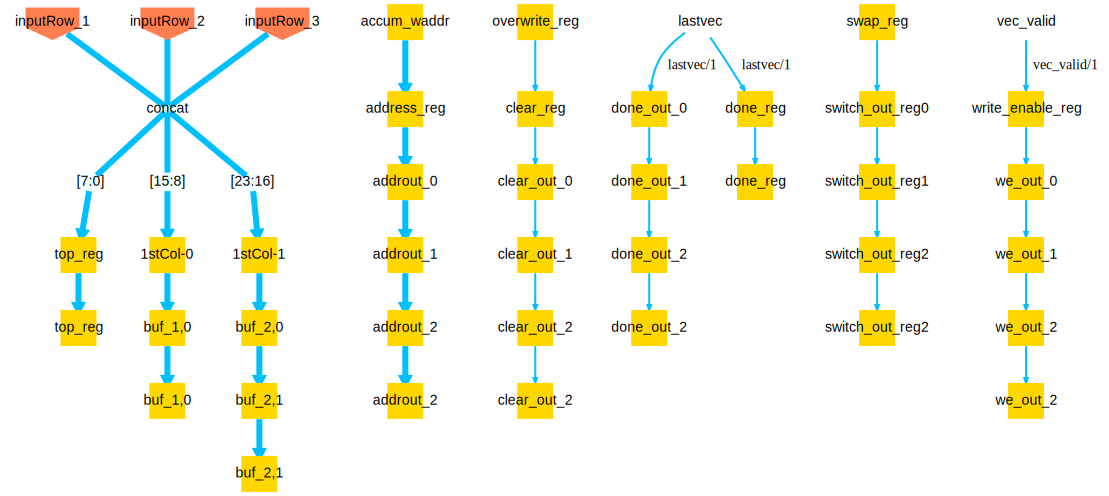

In [22]:
reset_working_block()

D_WIDTH = 8
MATSIZE = 3

accum_waddr = Register(32, "accum_waddr")
vec_valid = WireVector(1, "vec_valid")
overwrite_reg = Register(1, "overwrite_reg")
lastvec = WireVector(1, "lastvec")
swap_reg = Register(1, "swap_reg")

matin, switchout, addrout, weout, clearout, doneout = systolic_setup(
    data_width=D_WIDTH,
    matsize=MATSIZE,
    vec_in=concat_list(input_list([f"inputRow_{i+1}" for i in range(MATSIZE)], 8)),
    waddr=accum_waddr,
    valid=vec_valid,
    clearbit=overwrite_reg,
    lastvec=lastvec,
    switch=swap_reg,
)

SVG(block_to_svg(split_state=False))

### Matrix Multiply Unit

In [29]:
def MMU(
    data_width,
    matrix_size,
    accum_size,
    vector_in,
    accum_raddr,
    accum_waddr,
    vec_valid,
    accum_overwrite,
    lastvec,
    switch_weights,
    ddr_data,
    ddr_valid,
):  # , weights_in, weights_we):

    logn1 = 1
    while pow(2, logn1) < (matrix_size + 1):
        logn1 = logn1 + 1
    logn = 1
    while pow(2, logn) < (matrix_size):
        logn = logn + 1

    programming = Register(
        1, "mmu_program_new_weight_reg"
    )  # if high, we're programming new weights now
    waiting = WireVector(1)  # if high, a switch is underway and we're waiting

    weights_wait = Register(
        logn1, "mmu_weights_wait"
    )  # counts cycles since last weight push
    weights_count = Register(
        logn, "mmu_weights_count"
    )  # counts cycles of current weight push
    startup = Register(1, "mmu_startup")
    startup.next <<= 1  # 0 only in first cycle
    weights_we = WireVector(1, "mmu_weights_we")
    done_programming = WireVector(1, "mmu_done_programming")
    first_tile = Register(
        1, "mmu_first_tile"
    )  # Tracks if we've programmed the first tile yet

    # rtl_assert(~(switch_weights & (weights_wait != 0)), Exception("Weights are not ready to switch. Need a minimum of {} + 1 cycles since last switch.".format(matrix_size)))

    # FIFO
    weights_tile, tile_ready, full = FIFO(
        matsize=matrix_size,
        mem_data=ddr_data,
        mem_valid=ddr_valid,
        advance_fifo=done_programming,
    )
    # probe(tile_ready, "tile_ready")
    # probe(weights_tile, "FIFO_weights_out")

    matin, switchout, addrout, weout, clearout, doneout = systolic_setup(
        data_width=data_width,
        matsize=matrix_size,
        vec_in=vector_in,
        waddr=accum_waddr,
        valid=vec_valid,
        clearbit=accum_overwrite,
        lastvec=lastvec,
        switch=switch_weights,
    )

    mouts = MMArray(
        data_width=data_width,
        matrix_size=matrix_size,
        data_in=matin,
        new_weights=switchout,
        weights_in=weights_tile,
        weights_we=weights_we,
    )

    accout, done = accumulators(
        accsize=accum_size,
        datas_in=mouts,
        waddr=addrout,
        we=weout,
        wclear=clearout,
        raddr=accum_raddr,
        lastvec=doneout,
    )

    switchstart = switchout[0]
    totalwait = Const(matrix_size + 1)
    waiting <<= weights_wait != totalwait  # if high, we have to wait

    # probe(waiting, "waiting")

    with conditional_assignment:
        with ~startup:  # when we start, configure values to be ready to accept a new tile
            weights_wait.next |= totalwait
        with waiting:  # need to wait for switch to finish propagating
            weights_wait.next |= weights_wait + 1
        with ~first_tile & tile_ready:  # start programming the first tile
            weights_wait.next |= (
                totalwait  # we don't have to swait for a switch to clear
            )
            programming.next |= 1  # begin programming weights
            weights_count.next |= 0
            first_tile.next |= 1
        with switchstart:  # Weight switch initiated; begin waiting
            weights_wait.next |= 0
            programming.next |= 1
            weights_count.next |= 0
        with programming:  # We're pushing new weights now
            with weights_count == Const(matrix_size - 1):  # We've reached the end
                programming.next |= 0
                done_programming |= 1
            with (
                otherwise
            ):  # Still programming; increment count and keep write signal high
                weights_count.next |= weights_count + 1
                weights_we |= 1

    """
    with conditional_assignment:
        with startup == 0:  # When we start, we're ready to push weights as soon as FIFO is ready
            weights_wait.next |= totalwait
        with switchout:  # Got a switch signal; start wait count
            weights_wait.next |= 1  
        with weights_wait != totalwait:  # Stall on the final number
            weights_wait.next |= weights_wait + 1
        with weights_count != 0:  # If we've started programming new weights, reset
            weights_wait.next |= 0
        with otherwise:
            pass

        with ~startup:
            pass
        with (weights_wait == totalwait) & tile_ready:  # Ready to push new weights in
            weights_count.next |= 1
        with weights_count == Const(matrix_size):  # Finished pushing new weights
            done_programming |= 1
            weights_count.next |= 0
        with otherwise:  # We're pushing weights now; increment count
            weights_count.next |= weights_count + 1
            weights_we |= 1
    """

    return accout, done

In [34]:
reset_working_block()


def build_all(input_vectors, weights_vectors):
    DATWIDTH = 8
    MATSIZE = 4
    ACCSIZE = 8

    L = len(input_vectors)

    ins = [probe(Input(DATWIDTH)) for i in range(MATSIZE)]
    invec = concat_list(ins)
    swap = Input(1, "swap")
    waddr = Input(8, "waddr")
    lastvec = Input(1, "lastvec")
    valid = Input(1, "valid")
    raddr = Input(8, "raddr")  # accumulator read address to read out answers
    donesig = Output(1, "done")

    outs = [Output(32, name="out{}".format(str(i))) for i in range(MATSIZE)]

    # ws = [ Const(item, bitwidth=DATWIDTH) for sublist in weights_vectors for item in sublist ]  # flatten weight matrix
    # ws = concat_list(ws)  # combine weights into single wire
    ws = [
        item for sublist in weights_vectors for item in sublist
    ]  # flatten weight matrix
    print(ws)
    # ws = reduce(lambda x, y : (x<<8)+y, ws)  # "concat" weights into one integer

    weightsdata = Input(64 * 8, "weights_data")
    weightsvalid = Input(1, "weights_valid")

    accout, done = MMU(
        data_width=DATWIDTH,
        matrix_size=MATSIZE,
        accum_size=ACCSIZE,
        vector_in=invec,
        accum_raddr=raddr,
        accum_waddr=waddr,
        vec_valid=valid,
        accum_overwrite=Const(0),
        lastvec=lastvec,
        switch_weights=swap,
        ddr_data=weightsdata,
        ddr_valid=weightsvalid,
    )

    donesig <<= done
    for out, accout in zip(outs, accout):
        out <<= accout


weights = [[2, 2, 8, 6], [10, 6, 2, 8], [10, 9, 8, 1], [1, 3, 6, 4]]  # reversed

vectors = [
    [12, 7, 2, 6],
    [21, 21, 18, 8],
    [1, 4, 18, 11],
    [6, 3, 25, 15],
    [21, 12, 1, 15],
    [1, 6, 13, 8],
    [24, 25, 18, 1],
    [2, 5, 13, 6],
    [19, 3, 1, 17],
    [25, 10, 20, 10],
]

build_all(vectors, weights)

with open("systolic.svg", "w") as f:
    svg = block_to_svg(split_state=False)
    f.write(svg)

[2, 2, 8, 6, 10, 6, 2, 8, 10, 9, 8, 1, 1, 3, 6, 4]


### MMU Top Level Module

In [30]:
def MMU_top(
    data_width,
    matrix_size,
    accum_size,
    ub_size,
    start,
    start_addr,
    nvecs,
    dest_acc_addr,
    overwrite,
    swap_weights,
    ub_rdata,
    accum_raddr,
    weights_dram_in,
    weights_dram_valid,
):
    """

    Outputs
    ub_raddr: read address for unified buffer
    """

    # probe(ub_rdata, "ub_mm_rdata")

    accum_waddr = Register(accum_size, "mmuTOP_accum_waddr")
    vec_valid = WireVector(1, "mmuTOP_vec_valid")
    overwrite_reg = Register(1, "mmuTOP_overwrite_reg")
    last = WireVector(1, "mmuTOP_last")
    swap_reg = Register(1, "mmuTOP_swap_reg")

    busy = Register(1, "mmuTOP_busy_reg")
    N = Register(len(nvecs), "mmuTOP_nvecs")
    ub_raddr = Register(ub_size, "mmuTOP_ub_raddr")

    rtl_assert(
        ~(start & busy),
        Exception(
            "Cannot dispatch new MM instruction while previous instruction is still being issued."
        ),
    )

    # probe(vec_valid, "MM_vec_valid_issue")
    # probe(busy, "MM_busy")

    # Vector issue control logic
    with conditional_assignment:
        with start:  # new instruction being issued
            accum_waddr.next |= dest_acc_addr
            overwrite_reg.next |= overwrite
            swap_reg.next |= swap_weights
            busy.next |= 1
            N.next |= nvecs
            ub_raddr.next |= start_addr  # begin issuing next cycle
        with busy:  # We're issuing a vector this cycle
            vec_valid |= 1
            swap_reg.next |= 0
            N.next |= N - 1
            with N == 1:  # this was the last vector
                last |= 1
                overwrite_reg.next |= 0
                busy.next |= 0
            with otherwise:  # we're going to issue a vector next cycle as well
                ub_raddr.next |= ub_raddr + 1
                accum_waddr.next |= accum_waddr + 1
                last |= 0

    acc_out, done = MMU(
        data_width=data_width,
        matrix_size=matrix_size,
        accum_size=accum_size,
        vector_in=ub_rdata,
        accum_raddr=accum_raddr,
        accum_waddr=accum_waddr,
        vec_valid=vec_valid,
        accum_overwrite=overwrite_reg,
        lastvec=last,
        switch_weights=swap_reg,
        ddr_data=weights_dram_in,
        ddr_valid=weights_dram_valid,
    )

    # probe(ub_raddr, "ub_mm_raddr")

    return ub_raddr, acc_out, busy, done

### Test All

In [38]:
"""
Do we need full/stall signal from Matrix? Would need to stop SRAM out from writing to systolic setup
Yes: MMU needs to track when both buffers used and emit such a signal

The timing systems for weights programming are wonky right now. Both rtl_asserts are failing, but the
right answer comes out if you ignore that. It looks like the state machine that counts time since the
last weights programming keeps restarting, so the MMU thinks it's always programming weights?

Control signals propagating down systolic_setup to accumulators:
-Overwrite signal (default: accumulate)
-New accumulator address value (default: add 1 to previous address)
-Done signal?
"""


def testall(input_vectors, weights_vectors):
    reset_working_block()
    DATWIDTH = 8
    MATSIZE = 4
    ACCSIZE = 8

    L = len(input_vectors)

    ins = [probe(Input(DATWIDTH)) for i in range(MATSIZE)]
    invec = concat_list(ins)
    swap = Input(1, "swap")
    waddr = Input(8)
    lastvec = Input(1)
    valid = Input(1)
    raddr = Input(8, "raddr")  # accumulator read address to read out answers
    donesig = Output(1, "done")

    outs = [Output(32, name="out{}".format(str(i))) for i in range(MATSIZE)]

    # ws = [ Const(item, bitwidth=DATWIDTH) for sublist in weights_vectors for item in sublist ]  # flatten weight matrix
    # ws = concat_list(ws)  # combine weights into single wire
    ws = [
        item for sublist in weights_vectors for item in sublist
    ]  # flatten weight matrix
    print(ws)
    # ws = reduce(lambda x, y : (x<<8)+y, ws)  # "concat" weights into one integer

    weightsdata = Input(64 * 8)
    weightsvalid = Input(1)

    accout, done = MMU(
        data_width=DATWIDTH,
        matrix_size=MATSIZE,
        accum_size=ACCSIZE,
        vector_in=invec,
        accum_raddr=raddr,
        accum_waddr=waddr,
        vec_valid=valid,
        accum_overwrite=Const(0),
        lastvec=lastvec,
        switch_weights=swap,
        ddr_data=weightsdata,
        ddr_valid=weightsvalid,
    )

    donesig <<= done
    for out, accout in zip(outs, accout):
        out <<= accout

    sim_trace = SimulationTrace()
    sim = FastSimulation(tracer=sim_trace)

    # make a default input dictionary
    din = {
        swap: 0,
        waddr: 0,
        lastvec: 0,
        valid: 0,
        raddr: 0,
        weightsdata: 0,
        weightsvalid: 0,
    }
    din.update({ins[j]: 0 for j in range(MATSIZE)})

    # Give a few cycles for startup
    sim.step(din)

    # First, simulate memory read to feed weights to FIFO
    chunk = 64 * 8  # size of one dram read
    # ws = [ ws[i*chunk:i*chunk+chunk] for i in range(max(1,len(ws)/chunk)) ]  # divide weights into dram chunks
    # divide weights into dram-transfer sized chunks
    ws = reduce(lambda x, y: (x << 8) + y, ws)  # "concat" weights into one integer
    ws = [
        (ws >> (64 * 8 * i)) & pow(2, 64 * 8) - 1
        for i in range(max(1, len(weights_vectors) / 64))
    ]
    print(ws)
    for block in ws:
        d = din.copy()
        d.update({ins[j]: 0 for j in range(MATSIZE)})
        d.update({weightsdata: block, weightsvalid: 1})
        sim.step(d)

    # Wait until the FIFO is ready
    for i in range(10):
        sim.step(din)

    # din.update({ins[j]:0 for j in range(MATSIZE)})

    # Send signal to write weights
    # d = din.copy()
    # d[weights_we] = 1
    # sim.step(d)

    # Wait MATSIZE cycles for weights to propagate
    for i in range(MATSIZE * 2):
        sim.step(din)

    # Send the swap signal with first row of input
    d = din.copy()
    d.update({ins[j]: input_vectors[0][j] for j in range(MATSIZE)})
    d.update({swap: 1, valid: 1})
    sim.step(d)

    # Send rest of input
    for i in range(L - 1):
        d = din.copy()
        d.update({ins[j]: input_vectors[i + 1][j] for j in range(MATSIZE)})
        d.update({waddr: i + 1, lastvec: 1 if i == L - 2 else 0, valid: 1})
        sim.step(d)

    # Wait some cycles while it propagates
    for i in range(L * 2):
        d = din.copy()
        sim.step(d)

    # Read out values
    for i in range(L):
        d = din.copy()
        d[raddr] = i
        sim.step(d)

    with open("trace.vcd", "w") as f:
        sim_trace.print_vcd(f)


if __name__ == "__main__":
    # weights = [[1, 10, 10, 2], [3, 9, 6, 2], [6, 8, 2, 8], [4, 1, 8, 6]]  # transposed
    # weights = [[4, 1, 8, 6], [6, 8, 2, 8], [3, 9, 6, 2], [1, 10, 10, 2]]  # tranposed, reversed
    # weights = [[1, 3, 6, 4], [10, 9, 8, 1], [10, 6, 2, 8], [2, 2, 8, 6]]
    weights = [[2, 2, 8, 6], [10, 6, 2, 8], [10, 9, 8, 1], [1, 3, 6, 4]]  # reversed

    vectors = [
        [12, 7, 2, 6],
        [21, 21, 18, 8],
        [1, 4, 18, 11],
        [6, 3, 25, 15],
        [21, 12, 1, 15],
        [1, 6, 13, 8],
        [24, 25, 18, 1],
        [2, 5, 13, 6],
        [19, 3, 1, 17],
        [25, 10, 20, 10],
    ]

    testall(vectors, weights)

[2, 2, 8, 6, 10, 6, 2, 8, 10, 9, 8, 1, 1, 3, 6, 4]
[2669003323034818946175267059330647556]


# Weight Stationary Dataflow

like TPU architecture

## Simple Processing Element

We will use a weight stationary dataflow in our systolic array. Since weights need to be updated less frequently than the inputs or activations flowing through them, this will reduce the amount of memory IO and therefore the power requirements.  

To start, lets focus on building the most simple version of the processing element. Each element in the array will have the following inputs and outputs:

- activation value
- weight value
- partial sum

Activations will flow from left to right, weights will flow from top to bottom, and both are passed through unchanged.  
The accumulated value output will be the result of adding the accumulation input with the product of the current activation and weight.

In [310]:
from pyrtl import *
from hardware_accelerators.dtypes.base import BaseFloat
from dataclasses import dataclass
from typing import Type, Self


@dataclass
class PEOutputs:
    """Container for PE outputs to make connections clear"""

    data: Register  # Passes to PE to the right
    weight: Register  # Passes to PE below
    accum: Register  # Passes to PE below


class ProcessingElement:
    def __init__(
        self,
        data_type: Type[BaseFloat],
        accum_type: Type[BaseFloat],
        multiplier_type,
        adder_type,
        pipeline_mult: bool = False,
    ):
        """Initialize processing element hardware

        Args:
            data_type: Float type for data/weight (Float8, BF16 etc)
            accum_type: Float type for accumulation
            multiplier_type: Floating point multiplier implementation
            adder_type: Floating point adder implementation
            pipeline_mult: If True, register multiplication output before passing to accumulator

        TODO: Add control logic for:
        - Activation flow control
        - Accumulator reset/clear
        """
        # Get bit widths from format specs
        data_width = data_type.FORMAT_SPEC.total_bits
        accum_width = accum_type.FORMAT_SPEC.total_bits

        # Input/output registers
        self.data_reg = Register(bitwidth=data_width)
        self.weight_reg = Register(bitwidth=data_width)
        self.accum_in = WireVector(bitwidth=accum_width)
        self.accum_reg = Register(bitwidth=accum_width)

        # Control signals
        self.weight_we = WireVector(bitwidth=1)  # Weight write enable

        # Multiply-accumulate logic
        product = multiplier_type(
            self.data_reg,
            self.weight_reg,
            data_type.FORMAT_SPEC.exponent_bits,
            data_type.FORMAT_SPEC.mantissa_bits,
        )

        # TODO: Add float type conversion logic to pass different bitwidths to the accumulator

        if pipeline_mult:
            product_reg = Register(bitwidth=accum_width)
            product_reg.next <<= product
            sum_result = adder_type(
                product_reg,
                self.accum_in,
                accum_type.FORMAT_SPEC.exponent_bits,
                accum_type.FORMAT_SPEC.mantissa_bits,
            )
        else:
            sum_result = adder_type(
                product,
                self.accum_in,
                accum_type.FORMAT_SPEC.exponent_bits,
                accum_type.FORMAT_SPEC.mantissa_bits,
            )

        self.accum_reg.next <<= sum_result

        # Store registers in output container
        self.outputs = PEOutputs(
            data=self.data_reg, weight=self.weight_reg, accum=self.accum_reg
        )

    def connect_data(self, source: Self | WireVector):
        """Connect data input from source (PE or external input)"""
        if isinstance(source, ProcessingElement):
            self.data_reg.next <<= source.outputs.data
        else:
            self.data_reg.next <<= source

    def connect_weight(self, source: Self | WireVector):
        """Connect weight input from source (PE or external input)"""
        if isinstance(source, ProcessingElement):
            weight_in = source.outputs.weight
        else:
            weight_in = source

        # Conditional weight update based on enable signal
        with conditional_assignment:
            with self.weight_we:
                self.weight_reg.next |= weight_in

    def connect_accum(self, source: Self | WireVector):
        """Connect accumulator input from source (PE or external input)"""
        if isinstance(source, ProcessingElement):
            self.accum_in <<= source.outputs.accum
        else:
            self.accum_in <<= source

    def connect_weight_enable(self, enable: WireVector):
        """Connect weight write enable signal"""
        self.weight_we <<= enable

## Systolic Array Class

In [263]:
from typing import List, Type
from pyrtl import *
from dataclasses import dataclass


@dataclass
class SystolicArrayPorts:
    """Container for array I/O ports"""

    # Input ports for each row/column
    data_in: List[WireVector]  # Input activations flowing left->right
    weights_in: List[WireVector]  # Input weights flowing top->bottom
    weight_load: WireVector  # Weight load enable signal (1-bit)
    # Output ports from bottom row
    results_out: List[WireVector]  # Output partial sums


class SystolicArray:
    def __init__(
        self,
        size: int,
        data_type: Type[BaseFloat],
        accum_type: Type[BaseFloat],
        multiplier_type,
        adder_type,
        pipeline_mult: bool = False,
    ):
        """Initialize systolic array hardware structure

        Args:
            size: N for NxN array
            data_type: Number format for inputs (Float8, BF16)
            accum_type: Number format for accumulation
            multiplier_type: Multiplier implementation to use
            adder_type: Adder implementation to use
            pipeline_mult: Add pipeline register after multiplication
        """
        self.size = size
        self.data_type = data_type
        self.accum_type = accum_type

        # Create interface wires
        data_width = data_type.FORMAT_SPEC.total_bits
        accum_width = accum_type.FORMAT_SPEC.total_bits

        self.data_in = [WireVector(bitwidth=data_width) for _ in range(size)]
        self.weights_in = [WireVector(bitwidth=data_width) for _ in range(size)]
        self.weight_load = WireVector(bitwidth=1)
        self.results_out = [WireVector(bitwidth=accum_width) for _ in range(size)]

        # Create PE array
        self.pe_array = [
            [
                ProcessingElement(
                    data_type, accum_type, multiplier_type, adder_type, pipeline_mult
                )
                for _ in range(size)
            ]
            for _ in range(size)
        ]

        # Connect PEs in systolic pattern
        self._connect_array()

        # Package ports for external access
        self.ports = SystolicArrayPorts(
            data_in=self.data_in,
            weights_in=self.weights_in,
            weight_load=self.weight_load,
            results_out=self.results_out,
        )

    def _connect_array(self):
        """Connect processing elements in systolic pattern

        Data flow patterns:
        - Activations flow left to right
        - Weights flow top to bottom
        - Partial sums flow top to bottom
        """
        for row in range(self.size):
            for col in range(self.size):
                pe = self.pe_array[row][col]

                # Connect activation input:
                # First column gets external input, others connect to PE on left
                if col == 0:
                    pe.connect_data(self.data_in[row])
                else:
                    pe.connect_data(self.pe_array[row][col - 1])

                # Connect weight input:
                # First row gets external input, others connect to PE above
                if row == 0:
                    pe.connect_weight(self.weights_in[col])
                else:
                    pe.connect_weight(self.pe_array[row - 1][col])

                # Connect accumulator input:
                # First row starts at 0, others connect to PE above
                if row == 0:
                    pe.connect_accum(Const(0))
                else:
                    pe.connect_accum(self.pe_array[row - 1][col])

                # Connect weight enable to all PEs
                pe.connect_weight_enable(self.weight_load)

                # Connect bottom row results to output ports
                if row == self.size - 1:
                    self.results_out[col] <<= pe.outputs.accum

    def connect_data_input(self, row: int, source: WireVector):
        """Connect data input for specified row"""
        assert 0 <= row < self.size
        self.data_in[row] <<= source

    def connect_weight_input(self, col: int, source: WireVector):
        """Connect weight input for specified column"""
        assert 0 <= col < self.size
        self.weights_in[col] <<= source

    def connect_weight_load(self, source: WireVector):
        """Connect weight load enable signal"""
        self.weight_load <<= source

    def connect_result_output(self, col: int, dest: WireVector):
        """Connect result output from specified column"""
        assert 0 <= col < self.size
        dest <<= self.results_out[col]

## Systolic Data Setup

In [257]:
class SystolicSetup:
    """Creates diagonal delay pattern for systolic array I/O

    For a 3x3 array, creates following pattern of registers:
    (R = register, -> = connection)

    Row 0:  [R] ------->
    Row 1:  [R]->[R] -->
    Row 2:  [R]->[R]->[R]

    - Each row i contains i+1 registers
    - Input connects to leftmost register
    - Output reads from rightmost register
    - Can be used for both input and output buffering
    """

    def __init__(self, size: int, data_width: int):
        """Initialize delay register network

        Args:
            size: Number of rows in network
            data_width: Bit width of data values
        """
        self.size = size
        self.data_width = data_width

        # Create input wires for each row
        self.inputs = [WireVector(bitwidth=data_width) for _ in range(size)]

        # Create delay register network - more delays for lower rows
        self.delay_regs = []
        self.outputs = [WireVector(bitwidth=data_width) for _ in range(size)]

        for i in range(size):  # Create num rows equal to the size of systolic array
            row: List[Register] = []
            # Number of buffer registers equals row index for lower triangular config
            for j in range(i + 1):
                row.append(Register(bitwidth=data_width))
                if j != 0:
                    # Left most register connects to inputs, others connect to previous reg
                    row[j].next <<= row[j - 1]

            # Connect row input and output
            row[0].next <<= self.inputs[i]
            self.outputs[i] <<= row[-1]
            self.delay_regs.append(row)

    def connect_input(self, row: int, source: WireVector):
        """Connect input for specified row"""
        assert 0 <= row < self.size
        self.inputs[row] <<= source

    def connect_output(self, row, dest: WireVector):
        """Connect final register in a buffer row to an output destination"""
        dest <<= self.outputs[row]

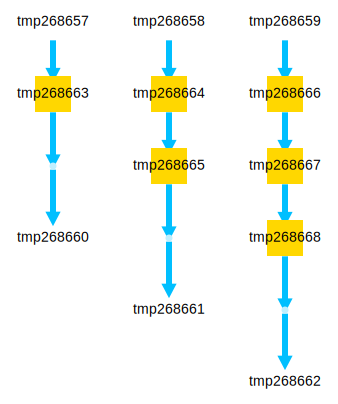

In [258]:
reset_working_block()

setup = SystolicSetup(size=3, data_width=8)

SVG(block_to_svg(split_state=False))

## Matrix Multiply Unit Top Level

In [269]:
class MatrixMultiplier:
    """Top level systolic array matrix multiplier hardware"""

    def __init__(
        self,
        size: int,
        data_type: Type[BaseFloat],
        accum_type: Type[BaseFloat],
        multiplier_type,
        adder_type,
        pipeline_mult: bool = False,
    ):
        self.size = size
        self.data_type = data_type
        self.accum_type = accum_type
        self.data_width = data_type.FORMAT_SPEC.total_bits
        self.accum_width = accum_type.FORMAT_SPEC.total_bits

        # Create hardware components
        self.systolic_array = SystolicArray(
            size, data_type, accum_type, multiplier_type, adder_type, pipeline_mult
        )
        self.systolic_setup = SystolicSetup(size, self.data_width)
        self.result_buffer = SystolicSetup(size, self.accum_width)

        # Connect internal components
        self._connect_internal_components()

    def _connect_internal_components(self):
        """Connect systolic array to input/output buffers"""
        for i in range(self.size):
            self.systolic_array.connect_data_input(i, self.systolic_setup.outputs[i])
            self.systolic_array.connect_result_output(
                i, self.result_buffer.inputs[-i - 1]
            )

    def _validate_wire_list(
        self, wires: List[WireVector], expected_width: int, purpose: str
    ):
        """Validate a list of wires meets requirements"""
        if len(wires) != self.size:
            raise ValueError(f"{purpose} requires {self.size} wires, got {len(wires)}")
        if not all(isinstance(w, WireVector) for w in wires):
            raise TypeError(f"All {purpose} must be WireVector instances")
        if not all(w.bitwidth == expected_width for w in wires):
            raise ValueError(f"All {purpose} must have bitwidth {expected_width}")

    def _split_wide_wire(
        self, wire: WireVector, width_per_slice: int
    ) -> List[WireVector]:
        """Split a wide wire into equal slices"""
        expected_width = width_per_slice * self.size
        if wire.bitwidth != expected_width:
            raise ValueError(
                f"Wide wire must have bitwidth {expected_width}, got {wire.bitwidth}"
            )
        # Use chop instead of manual slicing
        return chop(wire, *([width_per_slice] * self.size))

    def connect_weight_enable(self, enable: WireVector):
        """Connect weight enable signal"""
        if not isinstance(enable, WireVector) or enable.bitwidth != 1:
            raise ValueError("Weight enable must be 1-bit WireVector")
        self.systolic_array.connect_weight_load(enable)

    def connect_weights(self, weights: WireVector | List[WireVector]):
        """Connect weight inputs either as list of wires or single wide wire"""
        if isinstance(weights, list):
            self._validate_wire_list(weights, self.data_width, "weight inputs")
            weight_wires = weights
        else:
            # Split wide wire into individual weight wires
            weight_wires = chop(weights, *([self.data_width] * self.size))

        for i, wire in enumerate(weight_wires):
            self.systolic_array.connect_weight_input(i, wire)

    def connect_data(self, data: WireVector | List[WireVector]):
        """Connect data inputs either as list of wires or single wide wire"""
        if isinstance(data, list):
            self._validate_wire_list(data, self.data_width, "data inputs")
            data_wires = data
        else:
            # Split wide wire into individual data wires
            data_wires = chop(data, *([self.data_width] * self.size))

        for i, wire in enumerate(data_wires):
            self.systolic_setup.connect_input(i, wire)

    def connect_results(self, results: WireVector | List[WireVector]):
        """Connect result outputs either as list of wires or single wide wire"""
        if isinstance(results, list):
            self._validate_wire_list(results, self.accum_width, "result outputs")
            result_wires = results
        else:
            # Split wide wire into individual result wires
            result_wires = chop(results, *([self.accum_width] * self.size))

        for i, wire in enumerate(result_wires):
            self.result_buffer.connect_output(-i - 1, wire)

## Simulation Class

In [301]:
class MatrixMultiplierSimulator:
    def __init__(self, matrix_multiplier: MatrixMultiplier):
        self.mmu = matrix_multiplier
        self.size = matrix_multiplier.size
        self.data_type = matrix_multiplier.data_type
        self.accum_type = matrix_multiplier.accum_type

        # Create I/O ports
        self.weight_enable = Input(1, "weight_enable")
        self.weight_ports = [
            Input(self.mmu.data_width, f"weight_{i}") for i in range(self.size)
        ]
        self.data_ports = [
            Input(self.mmu.data_width, f"data_{i}") for i in range(self.size)
        ]
        self.result_ports = [
            Output(self.mmu.accum_width, f"result_{i}") for i in range(self.size)
        ]

        # Connect ports to matrix multiplier
        self.mmu.connect_weight_enable(self.weight_enable)
        self.mmu.connect_weights(self.weight_ports)
        self.mmu.connect_data(self.data_ports)
        self.mmu.connect_results(self.result_ports)

        # Initialize simulation
        self.sim = Simulation()
        self.sim_inputs = {
            "weight_enable": 0,
            **{f"weight_{i}": 0 for i in range(self.size)},
            **{f"data_{i}": 0 for i in range(self.size)},
        }

        # Initialize matrices as None
        self.matrix_a = None
        self.matrix_b = None
        self._iter_state = None
        self.result_matrix = np.zeros((self.size, self.size))

    def set_matrices(self, matrix_a: np.ndarray, matrix_b: np.ndarray):
        """Set input matrices and prepare simulation state"""
        # Verify dimensions
        assert (
            matrix_a.shape == matrix_b.shape == (self.size, self.size)
        ), f"Matrices must be {self.size}x{self.size}"

        # Convert matrices to specified datatype
        self.matrix_a = self._convert_matrix(matrix_a)
        self.matrix_b = self._convert_matrix(matrix_b)

        # Load weights into PEs
        self._load_weights()

    def calculate(self):
        while next(self):
            continue
        return self.result_matrix

    def matmul(self, matrix_a: np.ndarray, matrix_b: np.ndarray):
        self.set_matrices(matrix_a, matrix_b)
        return self.calculate()

    def _convert_matrix(self, matrix: np.ndarray) -> List[List[int]]:
        """Convert numpy matrix to list of binary values in specified datatype"""
        return [[self.data_type(x).binint for x in row] for row in matrix]

    def _load_weights(self):
        """Load weights into processing elements in reverse row order"""
        for row in reversed(range(self.size)):
            for col in range(self.size):
                self.sim_inputs[f"weight_{col}"] = self.matrix_b[row][col]
            self.sim_inputs["weight_enable"] = 1
            self.sim.step(self.sim_inputs)

        # Reset weight inputs
        for i in range(self.size):
            self.sim_inputs[f"weight_{i}"] = 0
        self.sim_inputs["weight_enable"] = 0
        self.sim.step(self.sim_inputs)

    def __iter__(self):
        """Initialize iterator state"""
        if self.matrix_a is None or self.matrix_b is None:
            raise RuntimeError("Matrices must be set before iteration")

        self._iter_state = {
            "row": self.size - 1,  # Start from last row
            "extra_cycles": self.size * 3 - 1,  # Cycles needed to flush results
            "phase": "input",  # 'input' or 'flush' phase
        }
        return self

    def __next__(self):
        """Return next simulation step results"""
        if self._iter_state is None:
            raise RuntimeError("Iterator not initialized")

        # If we're done with both phases, stop iteration
        if (
            self._iter_state["phase"] == "flush"
            and self._iter_state["extra_cycles"] == 0
        ):
            raise StopIteration

        # Handle input phase
        if self._iter_state["phase"] == "input":
            if self._iter_state["row"] < 0:
                # Transition to flush phase
                self._iter_state["phase"] = "flush"
                # Clear inputs
                for i in range(self.size):
                    self.sim_inputs[f"data_{i}"] = 0
            else:
                # Load next row of input data
                for col in range(self.size):
                    self.sim_inputs[f"data_{col}"] = self.matrix_a[
                        self._iter_state["row"]
                    ][col]
                self._iter_state["row"] -= 1

        # Handle flush phase
        if self._iter_state["phase"] == "flush":
            self._iter_state["extra_cycles"] -= 1

        # Step simulation
        self.sim.step(self.sim_inputs)

        # Return current results
        current_outputs = self.get_current_results()

        # Shift previous results down and insert new results at top
        self.result_matrix[1:] = self.result_matrix[:-1]
        self.result_matrix[0] = current_outputs

        return current_outputs

    def get_current_results(self) -> List[BaseFloat]:
        """Get current values from result output ports

        Returns:
            List of values currently present on the result output ports.
            Length will equal systolic array size (one value per column).
        """
        return [
            self.accum_type(binint=self.sim.inspect(f"result_{i}"))
            for i in range(self.size)
        ]

    def inspect_pe_array(self) -> dict[str, np.ndarray]:
        """Get current state of processing element array as dictionary of matrices

        Returns:
            Dictionary with keys 'data', 'weights', 'accum', where each value is
            a matrix showing the current values in the corresponding registers
            across the PE array
        """
        # Initialize matrices to store PE values
        data_matrix = np.zeros((self.size, self.size))
        weight_matrix = np.zeros((self.size, self.size))
        accum_matrix = np.zeros((self.size, self.size))

        # Populate matrices with current PE values
        for row in range(self.size):
            for col in range(self.size):
                pe = self.mmu.systolic_array.pe_array[row][col]

                # Convert binary values to float using appropriate data types
                data_matrix[row, col] = self.data_type(
                    binint=self.sim.inspect(pe.outputs.data.name)
                )
                weight_matrix[row, col] = self.data_type(
                    binint=self.sim.inspect(pe.outputs.weight.name)
                )
                accum_matrix[row, col] = self.accum_type(
                    binint=self.sim.inspect(pe.outputs.accum.name)
                )

        return {"data": data_matrix, "weights": weight_matrix, "accum": accum_matrix}

    def inspect_systolic_setup(self) -> str:
        """Visualize current state of systolic setup registers"""
        repr_str = ""
        for row in range(self.size):
            input_val = self.data_type(binint=self.sim.inspect(f"data_{row}"))
            repr_str += f"(input={input_val}) => "

            for reg in self.mmu.systolic_setup.delay_regs[row]:
                val = self.data_type(binint=self.sim.inspect(reg.name))
                repr_str += f"{val} -> "
            repr_str += "\n"
        return repr_str

In [ ]:
reset_working_block()

# Create hardware and simulator
mmu = MatrixMultiplier(
    size=3,
    data_type=BF16,
    accum_type=BF16,
    multiplier_type=lmul_simple,
    adder_type=float_adder,
)
simulator = MatrixMultiplierSimulator(mmu)

# Set input matrices
data = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
weights = np.identity(3)
simulator.set_matrices(data, weights)

# Iterate over simulation steps
for step, results in enumerate(simulator):
    print(f"Step {step} ({simulator._iter_state}):")

    print("Systolic Setup State:")
    print(simulator.inspect_systolic_setup())

    # Get PE array state
    print("PE Array State:")
    pe_state = simulator.inspect_pe_array()
    print("Data Values:")
    print(pe_state["data"])
    print("\nWeight Values:")
    print(pe_state["weights"])
    print("\nAccumulator Values:")
    print(pe_state["accum"])

    print("Current Results:")
    print([f"{float(x):.3f}" for x in results])

    print("-" * 80 + "\n")

Step 0 ({'row': 1, 'extra_cycles': 8, 'phase': 'input'}):
Systolic Setup State:
(input=7.0) => 0.0 -> 
(input=8.0) => 0.0 -> 0.0 -> 
(input=9.0) => 0.0 -> 0.0 -> 0.0 -> 

PE Array State:
Data Values:
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

Weight Values:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Accumulator Values:
[[1.21222855e-38 4.25000000e+00 4.25000000e+00]
 [8.50000000e+00 1.83670992e-38 8.50000000e+00]
 [1.27500000e+01 1.27500000e+01 2.46119130e-38]]
Current Results:
['4.250', '8.500', '12.750']
--------------------------------------------------------------------------------

Step 1 ({'row': 0, 'extra_cycles': 8, 'phase': 'input'}):
Systolic Setup State:
(input=4.0) => 7.0 -> 
(input=5.0) => 8.0 -> 0.0 -> 
(input=6.0) => 9.0 -> 0.0 -> 0.0 -> 

PE Array State:
Data Values:
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

Weight Values:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Accumulator Values:
[[1.21222855e-38 4.25000000e+00 4.25000000e+00]
 [4.25000000e+00 4.25000000e+00 8.50000000e+00]
 [1.27500

In [309]:
simulator.result_matrix

array([[1.0625, 2.125 , 3.125 ],
       [4.25  , 5.25  , 6.25  ],
       [7.25  , 8.5   , 9.5   ]])

---

# DiP: (diagonal input and permutated weight stationary)

Implementing the design found in the recent paper **[DiP: A Scalable, Energy-Efficient Systolic Array for Matrix Multiplication Acceleration](https://arc.net/l/quote/wllrwuvk)**

## Weight Matrix Permutation

In [316]:
def permutate_weight_matrix(arr: np.ndarray):
    # verify matrix is square
    rows, cols = arr.shape
    permutated = np.zeros((rows, cols))
    for i in range(cols):
        for j in range(rows):
            permutated[j][i] = arr[(j + i) % rows][i]
    return permutated

In [ ]:
x = np.array([[1, 2, 3], [3, 4, 5], [5, 6, 7]])
x, permutate_weight_matrix(x)

(array([[1, 2, 3],
        [3, 4, 5],
        [5, 6, 7]]),
 array([[1., 4., 7.],
        [3., 6., 3.],
        [5., 2., 5.]]))

## New Systolic Array

TODO: Need to combine this with other systolic array class and make the behavior parametrizeable!

This version does not require any FIFO or systolic setup making it much more efficient than the standard weight stationary approach!

In [322]:
size = 4

pe_array = [["" for _ in range(size)] for _ in range(size)]

for row in range(size):
    for col in range(size):
        pe = pe_array[row][col]

        # Connect weight input:
        # First row gets external input, others connect to PE above
        if row == 0:
            pe_array[row][col] = f"dataIn{col}"
        else:
            pe_array[row][col] = pe_array[row - 1][col - size + 1]

pe_array

[['dataIn0', 'dataIn1', 'dataIn2', 'dataIn3'],
 ['dataIn1', 'dataIn2', 'dataIn3', 'dataIn0'],
 ['dataIn2', 'dataIn3', 'dataIn0', 'dataIn1'],
 ['dataIn3', 'dataIn0', 'dataIn1', 'dataIn2']]

In [328]:
class SystolicArrayDiP(SystolicArray):
    def __init__(self, *args, **kwargs):
        """Initialize systolic array hardware structure in the DiP dataflow configuration

        Args:
            size: N for NxN array
            data_type: Number format for inputs (Float8, BF16)
            accum_type: Number format for accumulation
            multiplier_type: Multiplier implementation to use
            adder_type: Adder implementation to use
            pipeline_mult: Add pipeline register after multiplication
        """
        super().__init__(*args, **kwargs)

    def _connect_array(self):
        """Connect processing elements in the DiP pattern

        Data flow patterns:
        - Activations flow top to bottom, the last one in a row connects to the first of the next row
        - Weights flow top to bottom
        - Partial sums flow top to bottom
        """
        for row in range(self.size):
            for col in range(self.size):
                pe = self.pe_array[row][col]

                # Connect weight input:
                # First row gets external input, others connect to PE above
                if row == 0:
                    pe.connect_data(self.data_in[col])
                    pe.connect_weight(self.weights_in[col])
                else:
                    pe.connect_data(self.pe_array[row - 1][col - self.size + 1])
                    pe.connect_weight(self.pe_array[row - 1][col])

                # Connect accumulator input:
                # First row starts at 0, others connect to PE above
                if row == 0:
                    pe.connect_accum(Const(0))
                else:
                    pe.connect_accum(self.pe_array[row - 1][col])

                # Connect weight enable to all PEs
                pe.connect_weight_enable(self.weight_load)

                # Connect bottom row results to output ports
                if row == self.size - 1:
                    self.results_out[col] <<= pe.outputs.accum

In [329]:
SystolicArrayDiP(3, BF16, BF16, lmul_fast, float_adder)

called DiP connection function!
